In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# Configuration
OBSERVATION_START = '2023-01-01'
OBSERVATION_END = '2024-06-01'
HARDCODED_CHURN_THRESHOLD = 90  # Days without purchase

In [3]:
def generate_synthetic_data(num_customers=1000):
    """Generate synthetic transaction data with realistic patterns"""
    np.random.seed(42)
    customers = []
    start = pd.to_datetime(OBSERVATION_START)
    end = pd.to_datetime(OBSERVATION_END)
    
    for cust_id in range(1, num_customers + 1):
        # Base transaction pattern
        n_transactions = np.random.poisson(15)
        last_possible_date = end - timedelta(days=np.random.randint(1, 180))
        
        # Generate transaction dates with clustering
        transaction_dates = sorted([
            last_possible_date - timedelta(days=np.random.exponential(30)) 
            for _ in range(max(1, n_transactions))
        ])
        
        # Filter dates within observation window
        transaction_dates = [d for d in transaction_dates if start <= d <= end]
        
        for date in transaction_dates:
            customers.append({
                'customer_id': f"C{cust_id:04d}",
                'transaction_date': date,
                'amount': np.random.gamma(shape=2, scale=20)  # Synthetic purchase amount
            })
    
    return pd.DataFrame(customers)

def calculate_inactivity_periods(transactions):
    """Calculate max inactivity periods per customer"""
    customer_activity = transactions.groupby('customer_id')['transaction_date'].agg(['min', 'max'])
    customer_activity.columns = ['first_transaction', 'last_transaction']
    
    # Calculate gaps between consecutive transactions
    transactions = transactions.sort_values(['customer_id', 'transaction_date'])
    transactions['prev_date'] = transactions.groupby('customer_id')['transaction_date'].shift()
    transactions['gap'] = (transactions['transaction_date'] - transactions['prev_date']).dt.days
    
    # Find maximum gap per customer
    max_gaps = transactions.groupby('customer_id')['gap'].max().reset_index()
    customer_activity = customer_activity.merge(max_gaps, on='customer_id', how='left')
    
    return customer_activity.fillna(0)  # Fill NaNs for single-transaction customers

def determine_churn_status(customer_activity, churn_threshold):
    """Determine churn status based on threshold"""
    customer_activity['churned'] = (
        (pd.to_datetime(OBSERVATION_END) - customer_activity['last_transaction']).dt.days > churn_threshold
    ).astype(int)
    return customer_activity

def calculate_survival_metrics(customer_activity):
    """Calculate survival analysis metrics"""
    customer_activity['T'] = (
        customer_activity[['last_transaction', 'first_transaction']].apply(
            lambda x: (min(x.iloc[0], pd.to_datetime(OBSERVATION_END)) - x.iloc[1]).days,
            axis=1
            # lambda x: (min(x[0], pd.to_datetime(OBSERVATION_END)) - x[1]).days
        )
    )
    return customer_activity

71.0
Data-driven churn threshold: 71 days


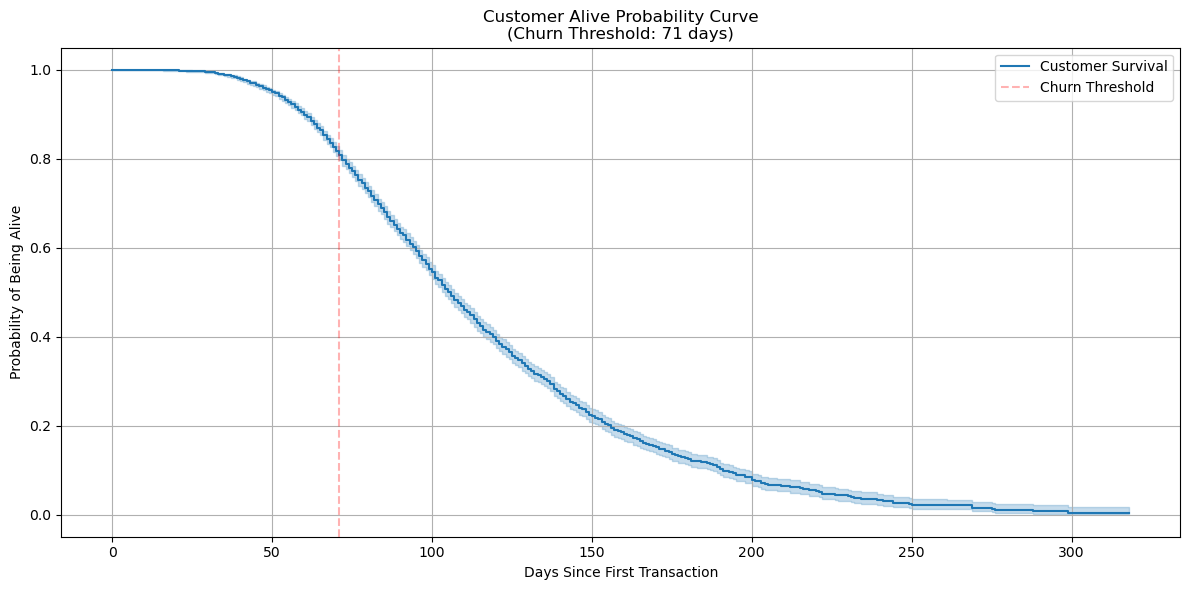

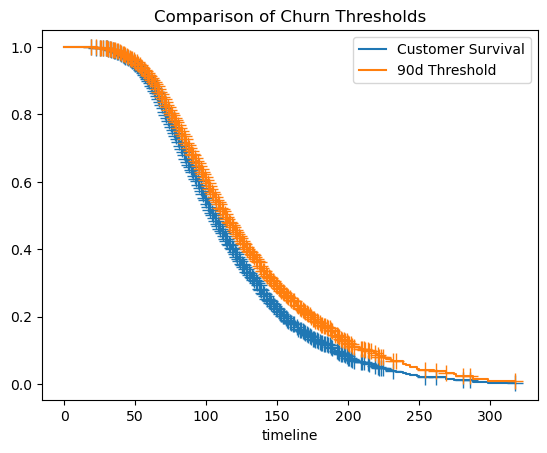

In [5]:
# --- Main Execution ---
if __name__ == "__main__":
    # Step 1: Generate or load transaction data
    # transactions = pd.read_csv('real_transactions.csv')  # For real data
    transactions = generate_synthetic_data(5000)
    
    # Step 2: Calculate inactivity periods
    customer_activity = calculate_inactivity_periods(transactions)
    
    # Step 3: Determine churn threshold (data-driven)
    gap_percentiles = customer_activity['gap'].quantile([0.75, 0.85, 0.90, 0.95])
    data_driven_threshold = int(gap_percentiles[0.90])  # 90th percentile
    print(f"Data-driven churn threshold: {data_driven_threshold} days")
    
    # Step 4: Apply churn definition
    customer_activity = determine_churn_status(customer_activity, data_driven_threshold)
    
    # Step 5: Prepare survival analysis data
    survival_data = calculate_survival_metrics(customer_activity)
    
    # Step 6: Fit Kaplan-Meier model
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=survival_data['T'],
        event_observed=survival_data['churned'],
        label='Customer Survival'
    )
    
    # Step 7: Plot results
    plt.figure(figsize=(12, 6))
    kmf.plot_survival_function()
    plt.title(f'Customer Alive Probability Curve\n(Churn Threshold: {data_driven_threshold} days)')
    plt.xlabel('Days Since First Transaction')
    plt.ylabel('Probability of Being Alive')
    plt.axvline(data_driven_threshold, color='r', linestyle='--', alpha=0.3, label='Churn Threshold')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Optional: Compare with hardcoded threshold
    hardcoded_data = determine_churn_status(customer_activity, HARDCODED_CHURN_THRESHOLD)
    kmf_hardcoded = KaplanMeierFitter()
    kmf_hardcoded.fit(
        durations=hardcoded_data['T'],
        event_observed=hardcoded_data['churned'],
        label=f'{HARDCODED_CHURN_THRESHOLD}d Threshold'
    )
    
    ax = kmf.plot_survival_function(show_censors=True, ci_show=False)
    kmf_hardcoded.plot_survival_function(ax=ax, show_censors=True, ci_show=False)
    plt.title('Comparison of Churn Thresholds')
    plt.legend()
    plt.show()